Authour : Rayane BOUGUERA <br>
Linkdin : https://www.linkedin.com/in/rayane-bouguera/

# Library

In [502]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import vectorbt as vbt
import base64
import plotly.express as px
import plotly.graph_objects as go
import requests
from datetime import datetime
from time import mktime
from bs4 import BeautifulSoup
import re  # regular expressions
from io import StringIO, BytesIO
from urllib.request import Request, urlopen
import json
import ta
import pandas_ta as pda
import mplfinance as mpf
import matplotlib.dates as mpl_dates
from statistics import mean
import re
import graphviz
from plotly.offline import iplot
from plotly.subplots import make_subplots
# for the initial split to a train set and a untouched test set
from sklearn.model_selection import train_test_split
# for roll forward cross vallidation
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.simplefilter(action='ignore')


# Yahoo finance function for data importation

In [2]:
def currentTime():
    return []


def updateDate():
    if len(currentTime()) > 0:
        currentTime().pop(0)
        currentTime().append(datetime.now())
    else:
        currentTime().append(datetime.now())


def get_crumbs_and_cookies(stock):
    """
    get crumb and cookies for historical df csv download from yahoo finance
    parameters: stock - short-handle identifier of the company 
    returns a tuple of header, crumb and cookie
    """

    url = 'https://finance.yahoo.com/quote/{}/history'.format(stock)
    with requests.session():
        header = {'Connection': 'keep-alive',
                  'Expires': '-1',
                  'Upgrade-Insecure-Requests': '1',
                  'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) \
                   AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.99 Safari/537.36'
                  }

        website = requests.get(url, headers=header)
        # soup = BeautifulSoup(website.text, 'lxml')
        soup = BeautifulSoup(website.text)
        crumb = re.findall('"CrumbStore":{"crumb":"(.+?)"}', str(soup))

        return (header, crumb[0], website.cookies)


def convert_to_unix(date):
    """
    converts date to unix timestamp
    parameters: date - in format (dd-mm-yyyy)
    returns integer unix timestamp
    """
    datum = datetime.strptime(date, '%d-%m-%Y')

    # adding 1 day due to timezone issue
    return int(mktime(datum.timetuple())) + 86400


def fnYFinHist(stock, interval='1d', day_begin='01-01-2013', day_end='17-11-2021'):
    """
    queries yahoo finance api to receive historical df in csv file format

    parameters: 
        stock - short-handle identifier of the company
        interval - 1d, 1wk, 1mo - daily, weekly monthly df
        day_begin - starting date for the historical data (format: dd-mm-yyyy)
        day_end - final date of the data (format: dd-mm-yyyy)

    returns a list of comma seperated value lines
    """

    day_begin_unix = convert_to_unix(day_begin)
    day_end_unix = convert_to_unix(day_end)
    header, crumb, cookies = get_crumbs_and_cookies(stock)

    with requests.session():
        url = 'https://query1.finance.yahoo.com/v7/finance/download/' \
              '{stock}?period1={day_begin}&period2={day_end}&interval={interval}&events=history&crumb={crumb}' \
              .format(stock=stock,
                      day_begin=day_begin_unix, day_end=day_end_unix,
                      interval=interval, crumb=crumb)

        website = requests.get(url, headers=header, cookies=cookies)

    data = pd.read_csv(StringIO(website.text), parse_dates=[
                       'Date'], index_col=['Date'])
    data['Returns'] = data['Close'].pct_change()
    return data


def fnYFinJSON(stock, field):
    if not stock:
        return "entrer un ticker"
    else:
        urlData = "https://query2.finance.yahoo.com/v7/finance/quote?symbols="+stock
        webUrl = urlopen(urlData)
        if (webUrl.getcode() == 200):
            data = webUrl.read()
        else:
            print("Received an error from server, cannot retrieve results " +
                  str(webUrl.getcode()))
        yFinJSON = json.loads(data)

    try:
        tickerData = yFinJSON["quoteResponse"]["result"][0]
    except:
        return "N/A"
    if field in tickerData:
        return tickerData[field]
    else:
        return "N/A"


def grabPricing(ticker, field):
    fieldValue = fnYFinJSON(ticker, field)
    updateDate()
    return fieldValue


def grabPricingAll(ticker, interval, start, end):
    df = fnYFinHist(ticker, interval, start, end)
    updateDate()
    return df


# Import data


In [503]:
startDate = pd.to_datetime('2011-01-01')
dayStart = '{:%d-%m-%Y}'.format(startDate)

endDate = datetime.now()
dayEnd = '{:%d-%m-%Y}'.format(endDate)

stockDrop, interval = "AAPL", '1d'
df = grabPricingAll(stockDrop, interval, dayStart, dayEnd)

df.dropna(inplace=True)
df = df.drop(['Returns'], axis=1)


In [504]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-04,11.872857,11.875000,11.719643,11.831786,10.131257,309080800
2011-01-05,11.769643,11.940714,11.767857,11.928571,10.214132,255519600
2011-01-06,11.954286,11.973214,11.889286,11.918929,10.205873,300428800
2011-01-07,11.928214,12.012500,11.853571,12.004286,10.278964,311931200
2011-01-10,12.101071,12.258214,12.041786,12.230357,10.472541,448560000


In [505]:
df = df.dropna()
df.head()
df.shape

(2836, 6)

## Bollinger Bands indicator

In [506]:
df['Middle Band'] = df['Close'].rolling(window=50).mean()
df['Upper Band'] = df['Middle Band'] + \
    1.96*df['Close'].rolling(window=50).std()
df['Lower Band'] = df['Middle Band'] - \
    1.96*df['Close'].rolling(window=50).std()

# Price Target

In [507]:
df["close_nextday"] = df.Close.shift(-3)  # used as target prediction

In [508]:
df.head()
df.dtypes

Open             float64
High             float64
Low              float64
Close            float64
Adj Close        float64
Volume             int64
Middle Band      float64
Upper Band       float64
Lower Band       float64
close_nextday    float64
dtype: object

## Remove NA

In [509]:
df.dropna(inplace=True)

# Candlestick chart

In [510]:
# Create subplots with 2 rows; top for candlestick price, and bottom for bar volume
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=(
    '....', 'Volume'), vertical_spacing=0.1, row_width=[0.2, 0.7])

# ----------------
# Candlestick Plot
fig.add_trace(go.Candlestick(x=df.index,
                             open=df['Open'],
                             high=df['High'],
                             low=df['Low'],
                             close=df['Close'], showlegend=False,
                             name='candlestick'),
              row=1, col=1)

# Moving Average
fig.add_trace(go.Scatter(x=df.index,
                         y=df['Middle Band'],
                         line_color='black',
                         name='Middle Band'),
              row=1, col=1)

# Upper Bound
fig.add_trace(go.Scatter(x=df.index,
                         y=df['Upper Band'],
                         line_color='gray',
                         line={'dash': 'dash'},
                         name='upper band',
                         opacity=0.5),
              row=1, col=1)

# Lower Bound fill in between with parameter 'fill': 'tonexty'
fig.add_trace(go.Scatter(x=df.index,
                         y=df['Lower Band'],
                         line_color='gray',
                         line={'dash': 'dash'},
                         fill='tonexty',
                         name='lower band',
                         opacity=0.5),
              row=1, col=1)


# ----------------
# Volume Plot
fig.add_trace(go.Bar(x=df.index, y=df['Volume'], showlegend=False),
              row=2, col=1)

# Remove range slider; (short time frame)
fig.update(layout_xaxis_rangeslider_visible=False)

# Stock data has gaps in dates, specifically in weekends and holidays
# create a list of dates that are NOT included from start to end
date_gaps = [date for date in pd.date_range(
    start=dayStart, end=dayEnd) if date not in df.index.values]

# Update Xaxes
fig.update_xaxes(rangebreaks=[dict(values=date_gaps)])

fig.show()


In [511]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Middle Band',
       'Upper Band', 'Lower Band', 'close_nextday'],
      dtype='object')

## Initial split to a train set and a untouched test set


In [512]:
# predictors=['Open', 'High', 'Low', 'Close', 'Volume', 'EMA 10', 'EMA 30', 'RSI', 'OBV']

predictors = ['Open', 'High', 'Low', 'Close', 'Volume',
              'Middle Band', 'Upper Band', 'Lower Band']


prediction = ['close_nextday']

x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(
    df[predictors], df[prediction], test_size=0.3)


x = x_train_df.values  # selected features

y = y_train_df.values.ravel()  # labels

y = np.round(y, 4)

sc = StandardScaler(copy=True, with_mean=True, with_std=True)

x_normal = np.round(sc.fit_transform(x), 4)


## Roll forward cross validation


In [513]:
tss = TimeSeriesSplit(n_splits=5)
model_score = []

## Creating the Random Forest model


In [514]:
model = RandomForestRegressor(
    n_estimators=20, max_features="sqrt", max_depth=10, random_state=1)


## Cross validation and metrics


In [515]:
for train_index, test_index in tss.split(x):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    model_score.append(metrics.r2_score(
        y_test, y_pred, sample_weight=None, multioutput='uniform_average'))
    print('Model score= ', model_score)
    print('Importance of predictors: ', model.feature_importances_)
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(
        metrics.mean_squared_error(y_test, y_pred)))


TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

## Checking for erroneous values


In [516]:
np.isinf(y_test).sum(), np.isnan(y_test).sum()

(0, 0)

In [517]:
y_test = pd.Series(y_test)
(y_test[np.isnan(y_test)])

len(y_test)
points = range(y_test.shape[0])


## Quick plot of real values compared to predicted values


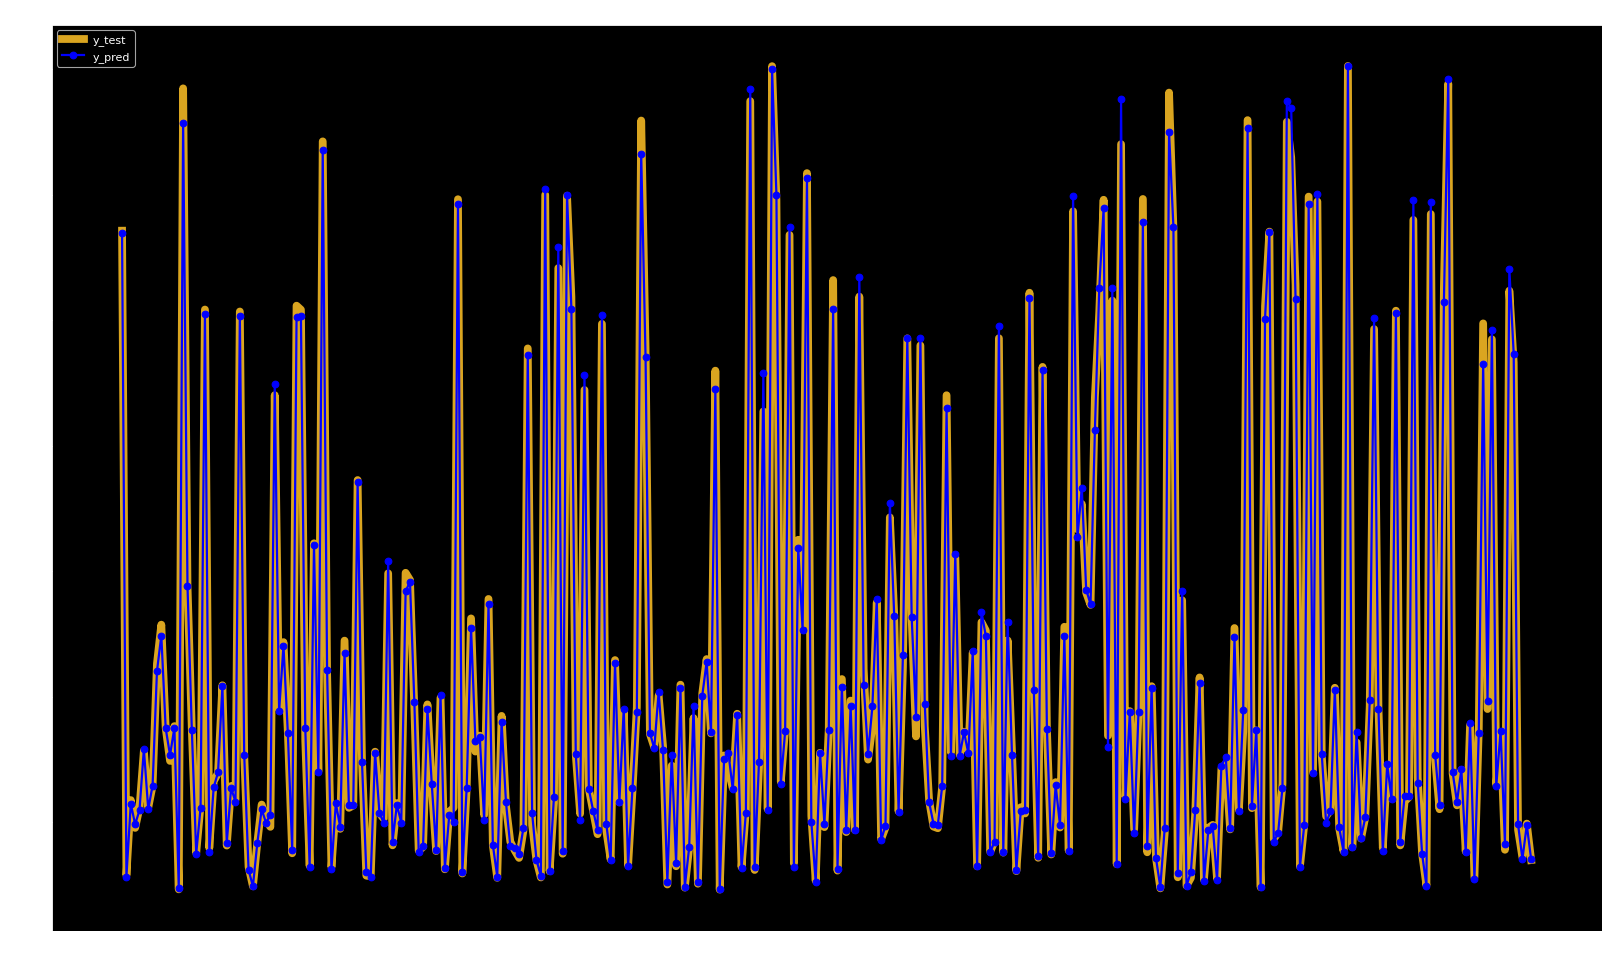

In [518]:
from matplotlib.pyplot import figure
plt.style.use('dark_background')
%matplotlib inline
figure(figsize=(25, 15), dpi=80)

plt.plot(points, y_test, color='goldenrod', label='y_test',linewidth = 7, alpha = 1)
plt.plot(points, y_pred,'go-', color='blue', label='y_pred', linewidth = 2, alpha = 1)
plt.ylabel('close prices')
plt.xlabel('days')
plt.title('Predicted Prices vs Actual Prices on test set')
plt.legend(loc='upper left')

## Predict values using the x_test_df set which is untouched


In [519]:
x_test_df['price_prediction'] = model.predict(x_test_df.loc[:, predictors])
x_test_df['model_signal'] = np.where(
    x_test_df.price_prediction > x_test_df.Close, 1, -1)  # Creating the signal


## Compute the return and strategy return


In [520]:
def compute_ret(df):
    # ret is daily returns
    df['ret'] = df.Close.shift(-1).pct_change()
    df['cum_ret'] = np.cumsum(df.ret)
    df['strategy_ret'] = df.ret * df.model_signal.shift(1)
    df['cum_strategy_ret'] = np.cumsum(df.strategy_ret)
    return df


In [521]:
df2 = compute_ret(x_test_df)
df2 = df2.sort_index(ascending=True)


## Plot the return of benchmark and strategy


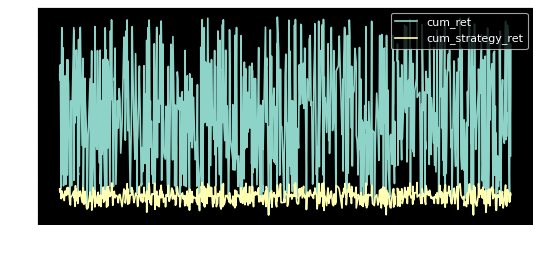

In [523]:
from matplotlib.pyplot import figure
plt.style.use('dark_background')
%matplotlib inline
figure(figsize=(25, 15), dpi=80)

df2['cum_ret'].plot(figsize=(8, 4))
df2['cum_strategy_ret'].plot(figsize=(8, 4))
plt.legend(loc='upper right')
plt.show()


In [490]:
def sharpe(df):
    sharpe_ratio = df.strategy_ret.mean()/df.strategy_ret.std()*np.sqrt(252)
    return sharpe_ratio

In [491]:
print(sharpe(df2))


0.38298451704870173


## Quick plot of real values compared to predicted values on untouched set


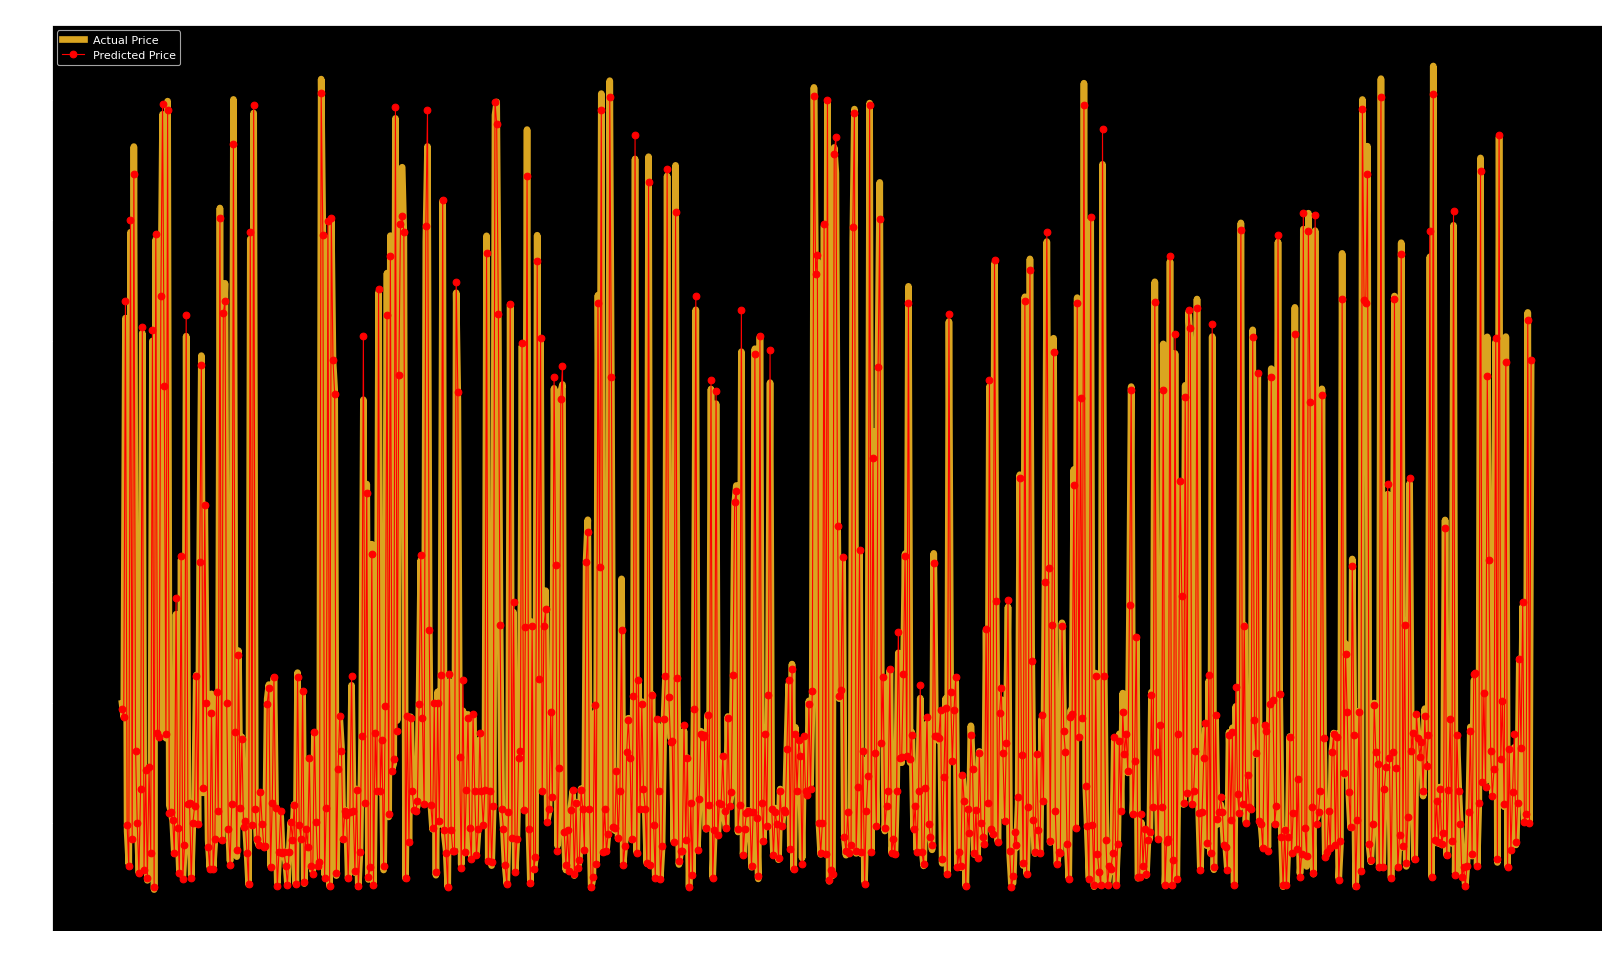

In [526]:
from matplotlib.pyplot import figure
plt.style.use('dark_background')
%matplotlib inline
figure(figsize=(25, 15), dpi=80)

plt.plot(range(len(y_test_df['close_nextday'])), y_test_df['close_nextday'], color='goldenrod', label='Actual Price',linewidth = 6, alpha = 1)
plt.plot(range(len(y_test_df['close_nextday'])), x_test_df['price_prediction'], 'go-', color='red', label='Predicted Price',linewidth = 1, alpha = 1)
plt.ylabel('close prices')
plt.xlabel('days')
plt.title('Predicted Prices vs Actual Prices on untouched set')
plt.legend(loc='upper left')


In [527]:
# Calculate the absolute errors
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

# Calculate feature importance and store in pandas series
print('')
print('feature importance : ')
feature_imp = pd.Series(model.feature_importances_,
                        index=predictors).sort_values(ascending=False)
feature_imp


Mean Absolute Error: 1.1
Accuracy: 97.92 %.

feature importance : 


High           0.365173
Open           0.242002
Close          0.157258
Low            0.111439
Middle Band    0.091832
Lower Band     0.020759
Upper Band     0.011274
Volume         0.000264
dtype: float64

# Backtest Best parameters 


In [110]:
best_parameters = []
windows = range(1, 50, 10)
lags = range(1, 50, 10)
trail = [0.001, 0.003, 0.005]
tp_profits = [0.002, 0.004, 0.006, 0.008]
sl_losses = [0.002, 0.004, 0.006, 0.008]


for window in windows:
    for lag in lags:
        for tp in tp_profits:
            for sl in sl_losses:
                for tr in trail:
                    df2['Middle Band'] = df2['Close'].rolling(
                        window=window).mean()
                    df2['Upper Band'] = df2['Middle Band'] + \
                        1.96*df2['Close'].rolling(window=window).std()
                    df2['Lower Band'] = df2['Middle Band'] - \
                        1.96*df2['Close'].rolling(window=window).std()

                    df2['entries_long'] = np.where(
                        df2['Close'] < df2['Lower Band'], True, False)
                    df2['exits_long'] = np.where(
                        df2['entries_long'].shift(lag), True, False)
                    df2['entries_short'] = np.where(
                        df2['Close'] > df2['Upper Band'], True, False)
                    df2['exits_short'] = np.where(
                        df2['entries_short'].shift(lag), True, False)

                    pf = vbt.Portfolio.from_signals(
                        sl_stop=sl,
                        tp_stop=tp,
                        sl_trail=tr,
                        close=df2['Close'],
                        entries=df2['entries_long'],
                        exits=df2['exits_long'],
                        short_entries=df2['entries_short'],
                        short_exits=df2['exits_short'],
                        direction='both',
                        accumulate=True
                    )
                    stats = pf.stats()
                    if stats['Profit Factor'] > 1.2:
                        print(
                            f'lag: {lag}, window: {window}, sl: {sl}, tp: {tp}, tr: {tr}, return: {stats["Total Return [%]"]}')
                        best_parameters.append({
                            'lag': lag,
                            'window': window,
                            'sl': sl,
                            'tp': tp,
                            'tr': tr,
                            'stat': stats
                        })


In [528]:
# window = 41
# lag = 31
# sl = 0.004
# tp = 0.006
# tr = 0.001

window = 41
lag = 31
sl = 0.01
tp = 0.03
tr = 0.015


df2['Middle Band'] = df2['Close'].rolling(
    window=window).mean()
df2['Upper Band'] = df2['Middle Band'] + \
    1.96*df2['Close'].rolling(window=window).std()
df2['Lower Band'] = df2['Middle Band'] - \
    1.96*df2['Close'].rolling(window=window).std()


df2['entries_long'] = np.where(
    (df2['Close'] <= df2['Lower Band']) & (df2['price_prediction'] >= df2['Close']), True, False)
df2['exits_long'] = np.where(
    df2['entries_long'].shift(lag), True, False)
df2['entries_short'] = np.where(
    (df2['Close'] >= df2['Upper Band']) & (df2['price_prediction'] <= df2['Close']), True, False)
df2['exits_short'] = np.where(
    df2['entries_short'].shift(lag), True, False)

pf = vbt.Portfolio.from_signals(
    sl_stop=sl,
    tp_stop=tp,
    sl_trail=tr,
    close=df2['Close'],
    entries=df2['entries_long'],
    exits=df2['exits_long'],
    short_entries=df2['entries_short'],
    short_exits=df2['exits_short'],
    direction='both',
    accumulate=True
)


In [529]:
pf.stats()

Start                         2011-03-16 00:00:00
End                           2022-04-01 00:00:00
Period                                        836
Start Value                                 100.0
End Value                              124.864413
Total Return [%]                        24.864413
Benchmark Return [%]                   1378.94916
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        13.784628
Max Drawdown Duration                       165.0
Total Trades                                   44
Total Closed Trades                            44
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            45.454545
Best Trade [%]                          14.140027
Worst Trade [%]                         -7.745984
Avg Winning Trade [%]                    4.334154
Avg Losing Trade [%]                    -2.516032


In [530]:
pf.plot().show()


# Visualizing a tree of the model

In [531]:
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38\bin'


In [532]:
for tree_in_forest in model.estimators_:
    dot = tree.export_graphviz(tree_in_forest,
                               feature_names=predictors,
                               filled=True,
                               rounded=True)


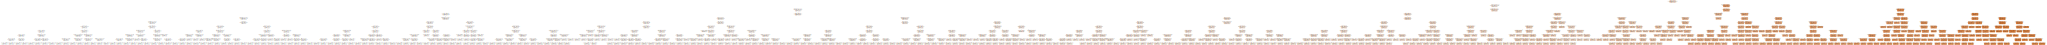

In [533]:
graphviz.Source(dot)


In [499]:
graphviz.Source(dot).view()

'Source.gv.pdf'

In [457]:
next = df[predictors].iloc[-1:]
next

,Open,High,Low,Close,Volume,Middle Band,Upper Band,Lower Band
Date,,,,,,,,
2022-03-31,1.116184,1.118306,1.1074,1.116184,0.0,1.118362,1.152142,1.084581


In [464]:
up = model.predict(next)